In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
#Подгружаем данные
df_train = pd.read_csv('train.csv', sep=',', encoding='utf8')
df_test = pd.read_csv('test.csv', sep=',', encoding='utf8')

In [3]:
#Помечаем тренировочный и тестовый сеты
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_train.append(df_test).reset_index(drop=True)

c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
#Выводим инфо
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
_id               41188 non-null object
age               41188 non-null int64
campaign          41188 non-null int64
cons.conf.idx     41188 non-null float64
cons.price.idx    41188 non-null float64
contact           41188 non-null object
day_of_week       41188 non-null object
default           41188 non-null object
duration          41188 non-null int64
education         41188 non-null object
emp.var.rate      41188 non-null float64
euribor3m         41188 non-null float64
housing           41188 non-null object
job               41188 non-null object
loan              41188 non-null object
marital           41188 non-null object
month             41188 non-null object
nr.employed       41188 non-null float64
pdays             41188 non-null int64
poutcome          41188 non-null object
previous          41188 non-null int64
sample            41188 non-null object
target     

In [10]:
#Создаем функцию обработки данных (удаляет ненужные столбцы, заменяет пропуски, кодирует категориальные признаки)
def preproc_data(df_input):
    df_output = df_input.copy()
    
    #Удаляем идентификатор и добавленный нами столбец sample (вернем его позже)
    df_output = df_output.drop(['_id','sample'], axis=1)
    #Заменяем unknown на NaN
    df_output = df_output.replace("unknown", np.nan)
    #Заменяем пропуска на моду
    df_output = df_output.fillna(df_output.mode().loc[0])
    #Кодируем категориальные признаки
    df_output = pd.get_dummies(df_output, columns=df_output.select_dtypes(include=object).columns)
    #Возвращаем sample
    df_output['sample'] = df_input['sample']
    
    return df_output

In [11]:
#Обабатываем функцией выше наш датафрейм, делим его на тренировочный и тестовый сеты
df_preproc = df.pipe(preproc_data)

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)
df_preproc = df_preproc.drop(['sample'], axis=1)

In [12]:
#Задаем таргет и удаляем его из датафреймов
from sklearn.model_selection import train_test_split

y = df_train_preproc['target']
X = df_train_preproc.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
#Объявляем модель и делаем предсказание
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#model = DecisionTreeClassifier()
#model = RandomForestClassifier()
model = LogisticRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
#Смотрим метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('precision', precision_score(y_test, predict))
print('recall', recall_score(y_test, predict))
print('accuracy', accuracy_score(y_test, predict))
print()

precision 0.6666666666666666
recall 0.4080664294187426
accuracy 0.9094955489614244



In [15]:
#Делаем кросс-валидацию и считаем средний roc_auc
from sklearn.model_selection import cross_val_score

cross_val_score = cross_val_score(model, X, y, scoring='roc_auc', cv=10)
print("Средний roc_auc:")
print(cross_val_score.mean())

c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\александр\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\александр\appdata\local\programs\py

Средний roc_auc:
0.9292139147034895


In [18]:
#Считаем roc_auc
from sklearn.metrics import roc_auc_score, roc_curve

predict_proba = model.predict_proba(X_test)
print('roc_auc', roc_auc_score(y_test, predict_proba[:,1]))

roc_auc 0.9334965653931064


(-0.01, 1.01)

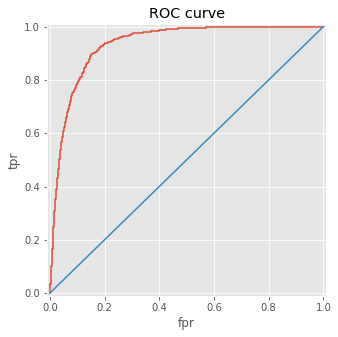

In [19]:
#Строим ROC кривую
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))